In [22]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataset_tools import *

In [ ]:
def process_batch(out_dir,imgs,masks,w,h,min_r,min_roi):
    cols = imgs.shape[2]//w
    rows = imgs.shape[1]//h
    imgs = imgs[:,:h*rows,:w*cols,:]
    masks = masks[:,:h*rows,:w*cols]
    imgs = np.transpose(imgs.reshape((-1,rows,h,cols,w,3)),(1,3,0,2,4,5)).reshape(cols*rows,len(imgs),h,w,3)
    masks = np.transpose(masks.reshape((-1,rows,h,cols,w)),(1,3,0,2,4)).reshape(cols*rows,len(masks),h,w)
    motion = np.zeros_like(masks)
    motion[masks > 240] = 1
    motion = motion.mean((2,3))

    roi = np.zeros_like(masks)
    roi[(masks > 240) | (masks < 10)] = 1
    roi = roi.mean((2,3))
    iter = 0
    for i in range(len(masks)):
        if(motion[i].mean() >= min_r and roi[i].mean() >= min_roi):
            cv2.imwrite(out_dir+'/%d_input.jpg'%(iter),ties_to_image(imgs[i]))
            cv2.imwrite(out_dir+'/%d_mask.png'%(iter),ties_to_image(masks[i]))
            iter+=1
    return imgs.reshape((-1,h,w,3))[motion.flatten()>=.97],iter


def save_motion(out_dir,motion_ties):
    if not (motion_ties is None):
        for i in range(int(np.ceil(float(len(motion_ties))/50.))):
            im = ties_to_image(motion_ties[i*50:min((i+1)*50,len(motion_ties))],5,10)
            cv2.imwrite(out_dir+'/%d_motion.jpg'%(i),im)
        return len(motion_ties)
    else:
        return 0

In [ ]:
def generate_ties(dataset,out_dir,length,tie_size,min_r=0,min_roi = 0.5):
    for video_num,(in_dir,out_dir) in enumerate(iterate_folders(dataset,out_dir)):
        ties_num = 0
        motion_ties = None
#         f = [int(ii) for ii in (open(in_dir+'/temporalROI.txt').read()).split(' ')]
#         end = f[-1]
#         for i in range(f[0],f[1]):
#             m = cv2.imread(in_dir+'/groundtruth/gt%06d.png'%(i))
#             if(m[((m > 10)&(m < 240))].size > 0.9*m.size):
#                 end = i
#                 break
#         batches = (end-f[0]-1)//length
#         print batches
        for batch_num,(imgs,masks) in enumerate(iterate_bathced(in_dir,length)):
                
#             if(batch_num == batches/2):
#                 m = save_motion(out_dir,motion_ties)
#                 print out_dir+ ' %d ties=%d motion=%d'%(batch_num,ties_num,m)
#                 if(m == 0):
#                     break
#                 out_dir = 'test/'+out_dir
#                 make_path(out_dir)
#                 motion_ties = None
#                 ties_num = 0
                
#             if(batch_num >= batches):
#                 break
            m_ties,i = process_batch(out_dir,imgs,masks,tie_size,tie_size,min_r,min_roi)
            ties_num += i
            if(len(m_ties) > 0):
                if not(motion_ties is None):
                    motion_ties = np.concatenate((motion_ties,m_ties))
                else:
                    motion_ties = m_ties
            
                 
        print out_dir+ ' %d ties=%d motion=%d'%(batch_num,ties_num,save_motion(out_dir,motion_ties))

In [ ]:
generate_ties('../gmm_segmentation/dataset','half_ties',256,32,-1.,0.95)

In [14]:
generate_ties('../gmm_segmentation/dataset','2_half_ties',256,32,-1.,0.95)

../gmm_segmentation/dataset/badWeather/skating 11 ties=0 motion=0
../gmm_segmentation/dataset/badWeather/snowFall 21 ties=0 motion=0
skip  ../gmm_segmentation/dataset/badWeather/wetSnow
../gmm_segmentation/dataset/badWeather/wetSnow 21 ties=0 motion=0
../gmm_segmentation/dataset/baseline/office 4 ties=0 motion=0
skip  ../gmm_segmentation/dataset/baseline/pedestrians
../gmm_segmentation/dataset/baseline/pedestrians 2 ties=0 motion=0
../gmm_segmentation/dataset/baseline/PETS2006 2 ties=0 motion=0
skip  ../gmm_segmentation/dataset/cameraJitter/boulevard
../gmm_segmentation/dataset/cameraJitter/boulevard 2 ties=0 motion=0
skip  ../gmm_segmentation/dataset/cameraJitter/sidewalk
../gmm_segmentation/dataset/cameraJitter/sidewalk 2 ties=0 motion=0
../gmm_segmentation/dataset/cameraJitter/traffic 1 ties=0 motion=0
skip  ../gmm_segmentation/dataset/dynamicBackground/canoe
../gmm_segmentation/dataset/dynamicBackground/canoe 0 ties=0 motion=0
../gmm_segmentation/dataset/dynamicBackground/fall 10 t

KeyboardInterrupt: 

In [8]:
import shutil
def purge(dir):
    for i in os.listdir(dir):
        for j in os.listdir(dir+'/'+i):
            p = dir+'/'+i+'/'+j
            l = [k[:-4] for k in os.listdir(p)]
            if( not('0_motion' in l)):
                print(p,'no motion ',len(l))
                shutil.rmtree(p)
            else:
                print(p,len(l))
purge('1_half_ties')          

('half_ties/badWeather/skating', 394)
('half_ties/badWeather/snowFall', 708)
('half_ties/baseline/office', 130)
('half_ties/baseline/PETS2006', 773)
('half_ties/cameraJitter/traffic', 129)
('half_ties/dynamicBackground/fall', 713)
('half_ties/intermittentObjectMotion/sofa', 131)
('half_ties/nightVideos/streetCornerAtNight', 245)
('half_ties/shadow/busStation', 129)


In [31]:
import numpy as np
import cv2
import os

def list_all_img(dir):
    res = []
    for i in os.listdir(dir):
        p = dir+'/'+i
        if(os.path.isdir(p)):
            res=res+list_all_img(p)
        elif (p[-4:] in ['.png','.jpg','.bmp']):
            res.append(p)
    return res

class IMDB:
    def __init__(self,all_paths,buffer_size):
        self.buffer_size = buffer_size
        self.all_paths = list_all_img(dir)
        self.data = dict()
        
    def __len__(self):
        return len(self.all_paths)
    
    def __getitem__(self,i):
        if(key in )
        arr = self.data[i]
        return cv2.imdecode(arr, cv2.CV_LOAD_IMAGE_UNCHANGED)
    
    def keys():
        return self.data.keys()
            

In [32]:
imdb = IMDB('train_ties/badWeather')

reading images 1592 99                                                


In [19]:
print len(imdb)

1593


In [24]:
im = imdb['/home/nvvaulin/development/dataset/train_ties/badWeather/skating/187_input.jpg']

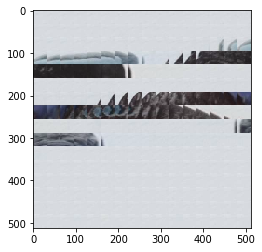

In [25]:
plt.imshow(im)
plt.show()

In [15]:
imdb.data.keys()

['/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/111_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/skating/18_motion.jpg',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/94_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/51_motion.jpg',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/45_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/skating/97_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/23_input.jpg',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/snowFall/70_motion.jpg',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/skating/269_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/skating/276_mask.png',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/wetSnow/25_input.jpg',
 '/home/nvvaulin/development/dataset/train_ties/badWeather/skating/302_mask.png',
 '/home/nv

In [7]:
list_all_img('/home/nvvaulin/development/dataset/train_ties/badWeather')

[]

$C_D = 